# Appartements

This notebook prepares the dataset with the new feature "closest stop" for the gradio deployement.

In [12]:
%pip install pandas numpy geopy gradio scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle



Note: you may need to restart the kernel to use updated packages.


In [13]:
# load the dataset
df = pd.read_csv('apartments_data_enriched_with_new_features.csv')

In [14]:
# Handling missing values
df = df.dropna()

In [15]:
# Encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Define features and target (Assuming 'Price' is the target variable)
X = df.drop(columns=['price'])  # Change 'Price' if your target is different
y = df['price']

In [16]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a model (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [17]:
# Save the trained model
with open("model.pkl", "wb") as f:
    pickle.dump((model, scaler, categorical_cols), f)

In [18]:
# Make predictions
y_pred = model.predict(X_test)

In [19]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error: 147.1098136645963
Mean Squared Error: 72996.13525962735
R² Score: 0.9394428423076894


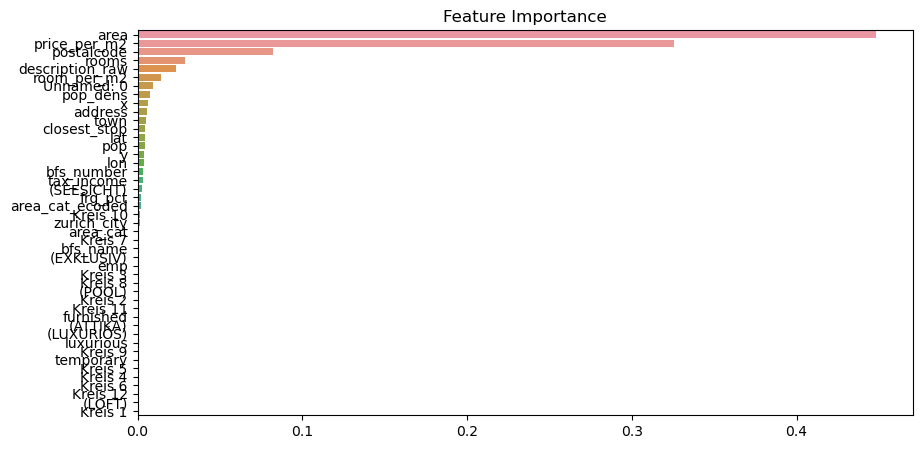

In [20]:
# Feature importance visualization
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title("Feature Importance")
plt.show()

In [21]:
# Function to get geolocation data
def get_geolocation(address):
    BASE_URL = "https://api3.geo.admin.ch/rest/services/api/SearchServer?"
    params = {"searchText": address, "origins": "address", "type": "locations"}
    response = requests.get(BASE_URL, params=params)
    
    if response.status_code == 200:
        data = response.json()
        results = data.get("results", [])
        if results:
            location = results[0]["attrs"]
            return location.get("lat"), location.get("lon"), location.get("x"), location.get("y")
    
    return None, None, None, None  # Default values if no result is found

In [22]:
# Prediction function
def predict_price(address, rooms, area, luxurious, zurich_city):
    with open("model.pkl", "rb") as f:
        model, scaler, categorical_cols = pickle.load(f)
    
    # Get geolocation data
    lat, lon, x, y = get_geolocation(address)
    
    # Convert input features into a DataFrame
    input_data = pd.DataFrame([[rooms, area, luxurious, zurich_city, lat, lon, x, y]],
                              columns=['Number of rooms', 'Area in m²', 'Luxurious', 'Zurich City', 'lat', 'lon', 'x', 'y'])
    
    # Encode categorical variables
    for col in categorical_cols:
        le = LabelEncoder()
        if col in input_data.columns:
            input_data[col] = le.fit_transform(input_data[col])
    
    # Scale numerical features
    input_data = scaler.transform(input_data)
    
    # Predict price
    prediction = model.predict(input_data)[0]
    return f"Predicted Price: {prediction}, Location: ({lat}, {lon})"

In [23]:
# Create Gradio interface
demo = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Textbox(label="Address"),
        gr.Number(label="Number of rooms"),
        gr.Number(label="Area in m²"),
        gr.Checkbox(label="Luxurious"),
        gr.Checkbox(label="Zurich City"),
    ],
    outputs="text",
    examples=[
        ["Zürcherstrasse 1, 8173 Neerach", 3.5, 65, False, False],
        ["Badenerstrasse 123, 8004 Zürich", 4, 98, False, True],
        ["Robert-Stephenson-Weg 47, 8004 Zürich", 4.5, 148, False, True]
    ],
    title="Apartment Price Predictor",
    description="Predict the price of an apartment in Zurich based on its location and features."
)

demo.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\ilias\anaconda3\lib\site-packages\gradio\queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
  File "c:\Users\ilias\anaconda3\lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "c:\Users\ilias\anaconda3\lib\site-packages\gradio\blocks.py", line 1935, in process_api
    result = await self.call_function(
  File "c:\Users\ilias\anaconda3\lib\site-packages\gradio\blocks.py", line 1520, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "c:\Users\ilias\anaconda3\lib\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "c:\Users\ilias\anaconda3\lib\site-packages\anyio\_backends\_asyncio.py", line 2461, in run_sync_in_worker_thread
    return await future
  File "c:\Users\ilias\anaconda3\lib\site-packages\anyio\_ba